In [1]:
import xarray as xr
import numpy as np
import datetime
from scipy.ndimage import gaussian_filter

import Utils as utl

from meteoSI import mod_ad

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import PlottingUtility as pltutl
import Colormaps

_FIG_SIZE = (14, 4.7)

font_settings = {
    'range_interval': [0, 6000],
    'fig_size': [15, 10],
    'rg_converter': True,
    'font_size': 15,
    'font_weight': 'normal',
    'zlabel': '',
}


# trained on >100 epochs of 60/600 (20181127-20190927)
voodoo_nc = '20190801-20190801-20201017-174440__20201017-174440_weights.h5.nc'
case = voodoo_nc[:8]
YYYY, MM, DD = int(case[:4]), int(case[4:6]), int(case[6:8]) 


In [2]:
# open the dataset using xarray
voodoo_xr = xr.open_mfdataset(f'data/{voodoo_nc}')

# convert to datetime
dt_list = [datetime.datetime.fromtimestamp(ts) for ts in voodoo_xr.ts.values]
print(voodoo_xr)
font_settings.update({'mask': voodoo_xr.mask.copy()})

# reclassify aerosol to aerosol&insects
voodoo_xr.voodoo_classification.values[voodoo_xr.voodoo_classification.values==8] = 10
voodoo_xr['voodoo_class_raw_nosmoothing'] = voodoo_xr.voodoo_classification.copy()

# look at important classes "ice", "ice and supercooled droplets", "cloud droplets only", and "drizzle/rain"
P_mixed = voodoo_xr['voodoo_classification_probabilities'][:, :, 5].copy()
P_droplets = voodoo_xr['voodoo_classification_probabilities'][:, :, 1].copy()

# all classes containing cloud droplets
P_allCD = P_droplets.copy()
P_allCD.values = P_mixed.values + P_droplets.values


<xarray.Dataset>
Dimensions:                                       (cl: 9, dt: 1081, nchannels: 6, nsamples: 51694, nvelocity: 256, rg: 292, ts: 1081)
Coordinates:
  * ts                                            (ts) float64 1.565e+09 ... 1.565e+09
  * dt                                            (dt) datetime64[ns] 2019-08-01T00:00:15.000001 ... 2019-08-01T08:59:45.000229
  * rg                                            (rg) float64 119.2 ... 1.196e+04
  * nsamples                                      (nsamples) int64 0 1 ... 51693
  * nvelocity                                     (nvelocity) int64 0 1 ... 255
  * nchannels                                     (nchannels) int64 0 1 2 3 4 5
  * cl                                            (cl) int64 0 1 2 3 4 5 6 7 8
Data variables:
    features                                      (nsamples, nvelocity, nchannels) float32 dask.array<shape=(51694, 256, 6), chunksize=(51694, 256, 6)>
    targets                                       

# Smooth the predictions using a Gaussian filter


In [3]:

P_allCD.values = gaussian_filter(P_allCD.values, sigma=1.0)


# calculate adiabatic liquid water path from temperature and pressure profiles
calculate  liquid water path for cloud droplet containing pixel, if $P(\hat{y}=1 \wedge \hat{y}=5) > 0.7$, for a prediction $\hat{y} = \mathrm{voodoo}(\mathrm{X})$

In [37]:
liquid_probability_threshold = 0.7
liquid_mask = P_allCD.values > liquid_probability_threshold

LWP = utl.calc_adLWP(liquid_mask, voodoo_xr.temperature.values, voodoo_xr.pressure.values, voodoo_xr.rg.values)


/Users/willi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


# plot adiabatic lwp / MWR lwp and probability for cloud droplets

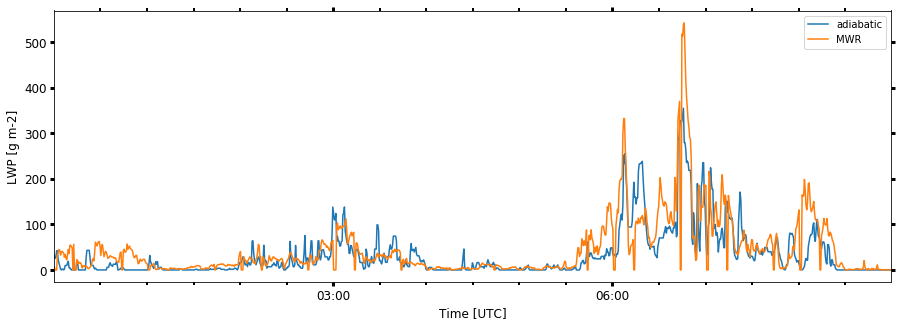

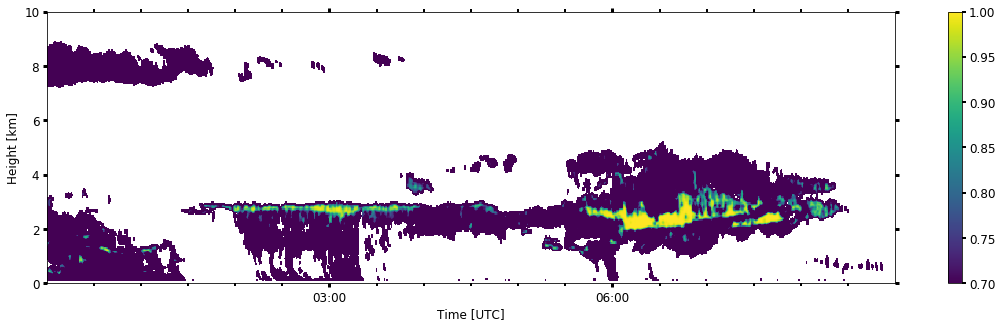

In [38]:

fig, ax = plt.subplots(ncols=1, figsize=(15, 5))
line = ax.plot(voodoo_xr.dt.values, LWP*50, label='adiabatic')
line = ax.plot(voodoo_xr.dt.values, voodoo_xr.lwp.values, label='MWR')
pltutl.load_xy_style(ax, ylabel='LWP [g m-2]')
ax.set_xlim([voodoo_xr.dt.values[0], voodoo_xr.dt.values[-1]])
ax.legend()

fig, ax = plt.subplots(ncols=1, figsize=(19., 5))
P_allCD.values = np.ma.masked_where(voodoo_xr.mask, P_allCD)
pmesh = ax.pcolormesh(voodoo_xr.dt.values, voodoo_xr.rg.values/1000., P_allCD.values.T, cmap='viridis', vmin=liquid_probability_threshold, vmax=1)
cbar = fig.colorbar(pmesh, ax=ax)
ax.set_ylim([0, 10])
pltutl.load_xy_style(ax, ylabel='Height [km]')
pltutl.load_cbar_style(cbar)


In [32]:

corr, corr_smothed = utl.correlation(voodoo_xr.lwp.values, LWP)
print(f'      correlation raw prediction = {corr:.2f}')
print(f'correlation smoothed predicitons = {corr_smothed:.2f}')
print(f' maximum liquid water path value = {LWP.max():.2f} [g m-2]') 


      correlation raw prediction = 0.80
correlation smoothed predicitons = 0.86
 maximum liquid water path value = 7.09 [g m-2]
